<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Question-2" data-toc-modified-id="Question-2-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Question 2</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import trange

# for generating BERT embeddings
from sentence_transformers import SentenceTransformer

# for dimensionality reduction and visualization
import umap.umap_ as umap

# for clustering
import hdbscan

# for visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# for getting the feature relevance while extracting top 10 features
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# for getting all the helper functions
import Scripts.helper_functions as hf

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.__version__

'1.21.6'

In [3]:
## reading the dataset
df_raw = pd.read_csv("input/raw_data.csv")

In [4]:
df = df_raw.copy(deep=True)

In [5]:
df['processed_content'] = df['content'].progress_apply(lambda x: hf.process_strings(x))

progress bar:   0%|          | 0/9185 [00:00<?, ?it/s]

In [6]:
## extracting keywords
df['keywords'] = df['processed_content'].progress_apply(lambda x: hf.return_keywords_rake(x, top_n=5))

progress bar:   0%|          | 0/9185 [00:00<?, ?it/s]

In [7]:
## creating the exploded view of the ids and the respective keywords
ls_for_df = []

for id in df.id.unique():
    for i, keyword in enumerate(df[df['id'] == id]['keywords'].iloc[0]):
        # print(str(id) + "_" + str(i+1) + "- " + keyword)
        ls_for_df.append([str(id) + "_" + str(i+1), keyword])

In [8]:
df_with_id_keywords = pd.DataFrame(ls_for_df, columns = ['modified_id', 'keyword'])

In [9]:
df_with_id_keywords.shape

(42850, 2)

In [10]:
# removing duplicated keywords (if any)
df_with_id_keywords['deduplication_string'] = df_with_id_keywords.apply(lambda x: x['modified_id'].split("_")[0] + ":" + x['keyword'], axis=1)
df_with_id_keywords['deduplication_flag'] = df_with_id_keywords['deduplication_string'].duplicated()
# removing all the duplicated rows
df_with_id_keywords = df_with_id_keywords[df_with_id_keywords['deduplication_flag'] == False]
df_with_id_keywords.drop(columns = ['deduplication_flag', 'deduplication_string'], inplace=True)

In [11]:
# creating the corpus of words before embedding
corpus = list(df_with_id_keywords['keyword'])
print(f"The length of the corpus is {len(corpus)}")

The length of the corpus is 42817


In [12]:
# ## create the embeddings
# embedder = SentenceTransformer('distilbert-base-nli-mean-tokens')
# corpus_embeddings = embedder.encode(corpus)

In [13]:
# # saving the corpus embedding as a pickle file
# with open('outputs/preprocessed/embeddings/keyword_embeddings.pickle', 'wb') as pkl:
#     pickle.dump(corpus_embeddings, pkl)

In [14]:
# reading the pickle file from the already generated embeddings
import pickle
with open('outputs/preprocessed/embeddings/keyword_embeddings.pickle', 'rb') as pkl:
    corpus_embeddings = pickle.load(pkl)

In [15]:
len(corpus_embeddings)

42817

In [16]:
## clustering using HDBSCAN (using UMAP for dimensionality reduction before clusting the embeddings)
clusterable_embedding = umap.UMAP(
    n_neighbors=40, # this should be kept large, because we want more number of values to come into a cluster
    min_dist=0.0, # this should be kept small as we want more tightly packed densities to be together
    n_components=2, #reducing dimension to 2
    random_state=42,
).fit_transform(corpus_embeddings)

In [17]:
labels = hdbscan.HDBSCAN(
    min_samples=50,
    min_cluster_size=210,
).fit_predict(clusterable_embedding)

In [18]:
len(set(labels))

38

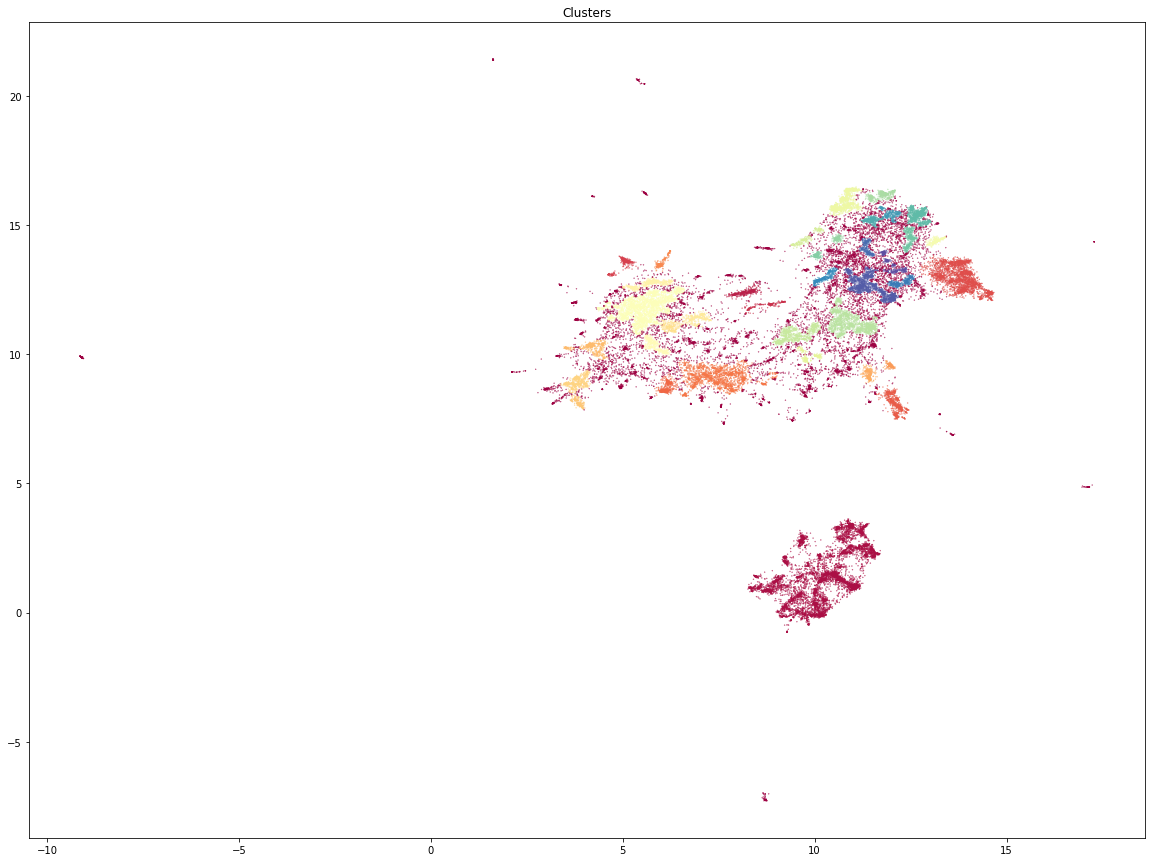

In [19]:
plt.figure(figsize=(20, 15))
plt.title("Clusters")
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], c=labels, s=0.1, cmap='Spectral');
plt.savefig('outputs/figures/cluster_vizualization.png', bbox_inches='tight')

In [20]:
df_cluster = df_with_id_keywords.copy(deep=True)
assert len(labels) == df_cluster.keyword.shape[0]
df_cluster['cluster'] = labels

In [21]:
df_cluster.cluster.unique()

array([-1, 25, 20,  0, 23,  5, 29, 24,  7, 34, 28, 35, 13,  4, 15, 22, 18,
        3, 32,  6,  9, 16, 14, 33, 17, 19, 11,  8, 31,  2, 30, 12, 27,  1,
       36, 21, 10, 26], dtype=int64)

In [22]:
cluster_texts = {}
for cluster in trange(-1, max(df_cluster.cluster.unique())+1):
    cluster_texts[str(cluster)] = "; ".join(text for text in df_cluster[df_cluster['cluster'] == cluster]['keyword'])

100%|█████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 464.96it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:41<00:00,  1.10s/it]


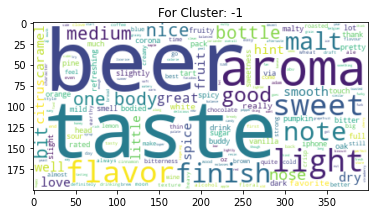

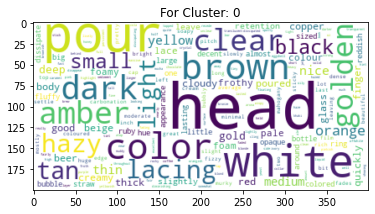

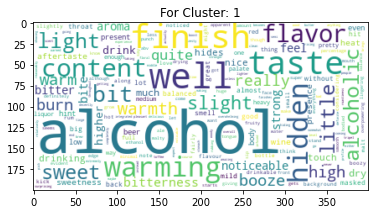

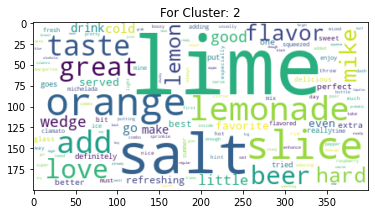

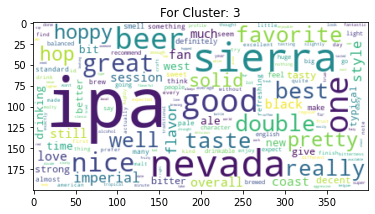

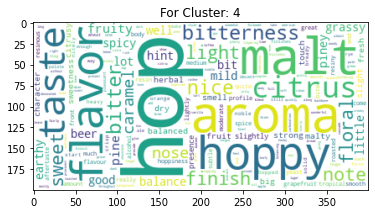

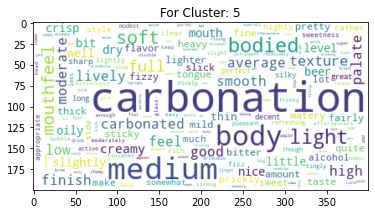

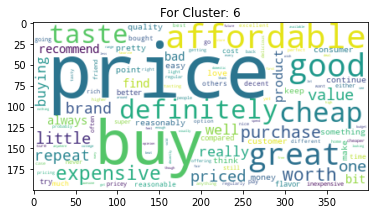

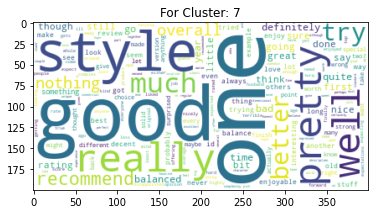

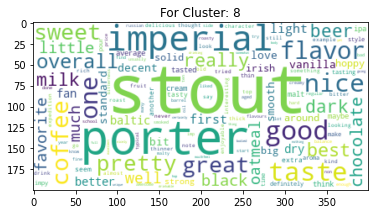

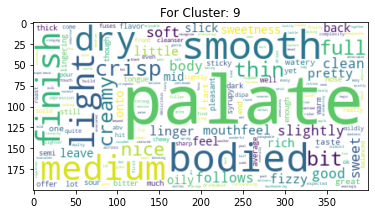

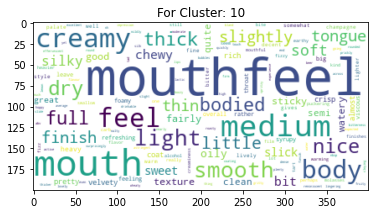

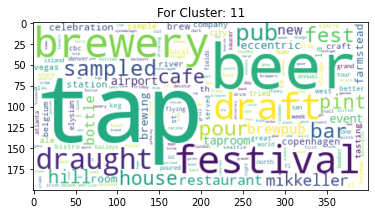

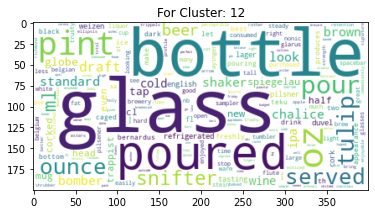

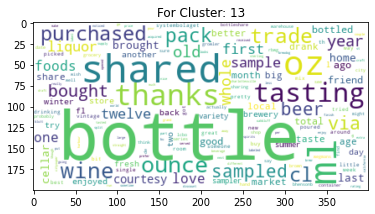

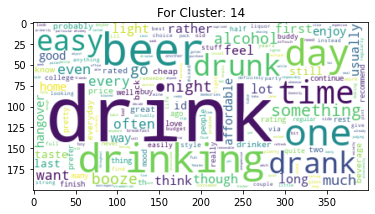

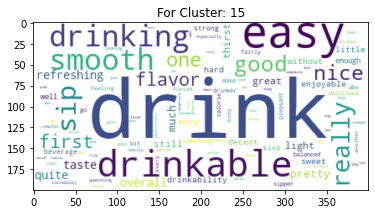

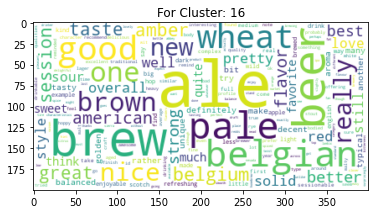

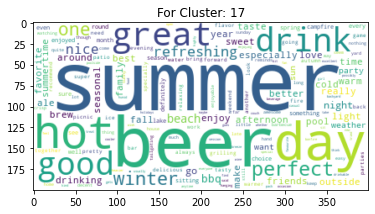

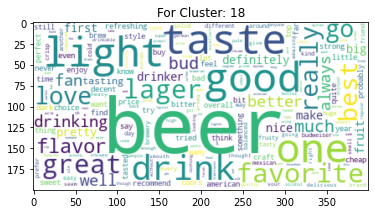

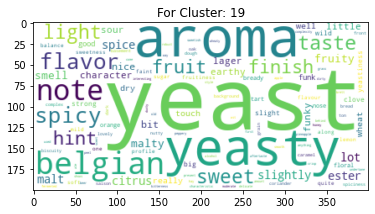

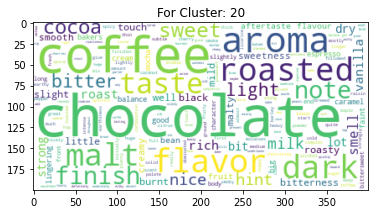

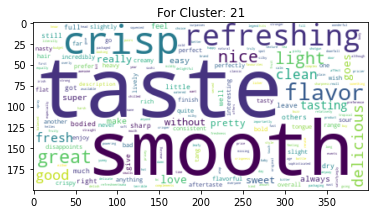

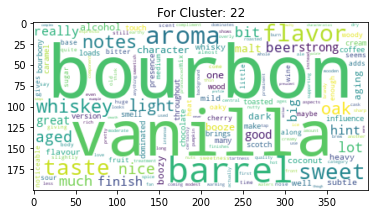

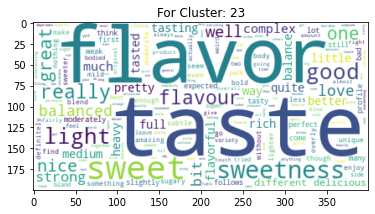

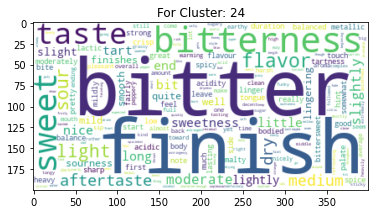

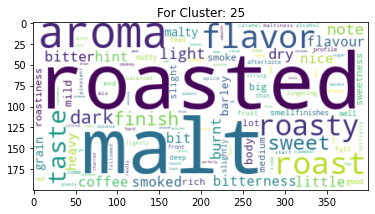

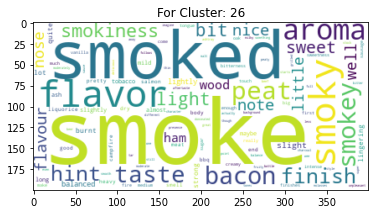

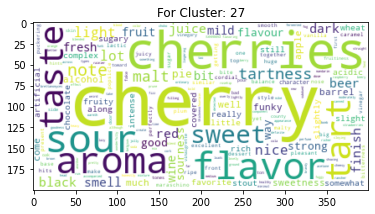

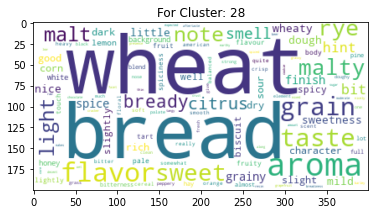

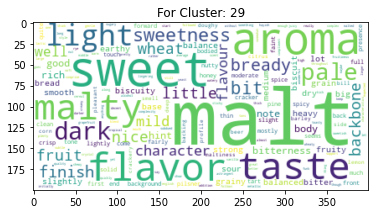

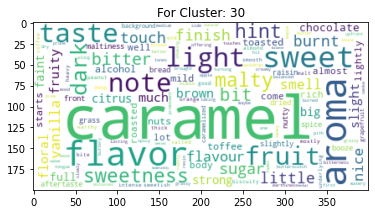

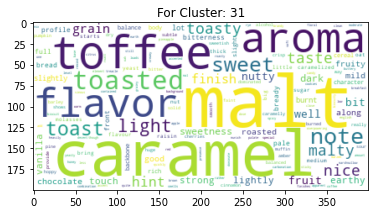

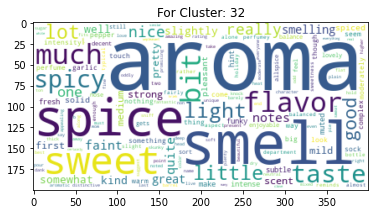

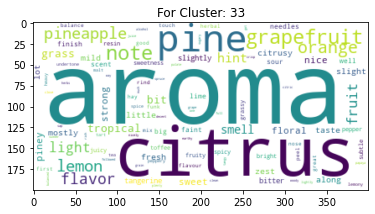

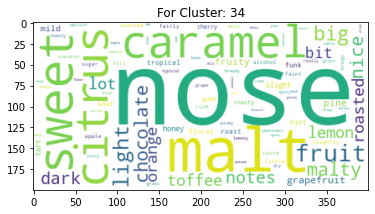

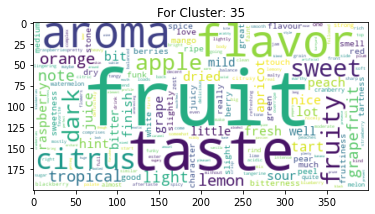

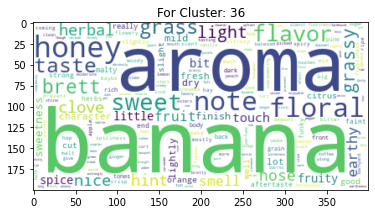

In [23]:
for cluster in trange(-1, max(df_cluster.cluster.unique())+1):
    #print(f"Generating Word Cloud for cluster {cluster}")
    # Creating word_cloud with text as argument 
    wc = WordCloud(collocations = False, background_color = 'white').generate(cluster_texts[str(cluster)])

    # Display the generated Word Cloud
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"For Cluster: {cluster}")
    plt.savefig(f"outputs/figures/wordclouds/cluster_{str(cluster)}_wordcloud.png", bbox_inches='tight')

In [24]:
## creating manual cluster mappings

cluster_mapping = {-1 : 'taste', 
0 : 'appearance', 
1 : 'alcohol', 
2 : 'ingredients', 
3 : 'style', 
4 : 'ingredients', 
5 : 'carbonation', 
6 : 'price', 
7 : 'style', 
8 : 'style', 
9 : 'palate', 
10 : 'taste', 
11 : 'place_of_service', 
12 : 'packaging', 
13 : 'packaging', 
14: 'noise', 
15 : 'style', 
16 : 'style', 
17: 'season', 
18 : 'taste', 
19 : 'ingredients', 
20 : 'ingredients', 
21 : 'taste', 
22 : 'style', 
23 : 'taste', 
24 : 'finish', 
25 : 'style', 
26 : 'style', 
27 : 'ingredients', 
28 : 'ingredients', 
29 : 'taste', 
30 : 'ingredients', 
31 : 'ingredients', 
32 : 'aroma', 
33 : 'aroma', 
34 : 'aroma', 
35 : 'taste',
36 : 'ingredients'}

In [25]:
df_cluster.replace({'cluster': cluster_mapping}, inplace=True)

In [26]:
df_cluster2 = df_cluster[df_cluster['cluster'] != 'noise']

In [27]:
df_cluster2['modified_id'] = df_cluster2['modified_id'].apply(lambda x: x.split("_")[0])

In [28]:
df_cluster2.head()

modified_id                 keyword      cluster
0        6254      soft carb full bod        taste
1        6254        dark roast malts        style
3        6254       dark roast coffee  ingredients
4        6254              dark brown   appearance
5        6347  hazy golden body large   appearance

In [29]:
df_cluster2.cluster.nunique()

13

In [30]:
## saving this file for use later on
df_cluster2.to_csv("outputs/preprocessed/review_attribute_exploded_tagging.csv", index=False)

In [31]:
## grouping by the 'modified_ids' and getting all the relevant attributes
id_attribute_mapping = df_cluster2.groupby(['modified_id']).agg({'cluster': 'unique'}).reset_index()

In [32]:
id_attribute_mapping['attribute'] = id_attribute_mapping['cluster'].apply(lambda x: ", ".join(x))

In [33]:
id_attribute_mapping.drop(columns=['cluster'], inplace=True)
id_attribute_mapping.rename(columns={'modified_id':'id'}, inplace=True)

In [34]:
id_attribute_mapping.to_csv("outputs/submission_files/sc26040_attributes.csv", index=False)

### Question 2

In [35]:
# arrange the dataframe such that we have the different attributes as each of the features and the rating as the target variable
df_with_attributes = pd.read_csv("outputs/preprocessed/review_attribute_exploded_tagging.csv")

In [36]:
df_with_attributes.head()

modified_id                 keyword      cluster
0         6254      soft carb full bod        taste
1         6254        dark roast malts        style
2         6254       dark roast coffee  ingredients
3         6254              dark brown   appearance
4         6347  hazy golden body large   appearance

In [37]:
df_with_attributes.cluster.nunique()

13

In [38]:
# one-hot encoding the different attributed
one_hot_encoded_data = pd.get_dummies(df_with_attributes, columns = ['cluster'])

In [39]:
one_hot_encoded_data.head()

modified_id                 keyword  cluster_alcohol  cluster_appearance  \
0         6254      soft carb full bod                0                   0   
1         6254        dark roast malts                0                   0   
2         6254       dark roast coffee                0                   0   
3         6254              dark brown                0                   1   
4         6347  hazy golden body large                0                   1   

   cluster_aroma  cluster_carbonation  cluster_finish  cluster_ingredients  \
0              0                    0               0                    0   
1              0                    0               0                    0   
2              0                    0               0                    1   
3              0                    0               0                    0   
4              0                    0               0                    0   

   cluster_packaging  cluster_palate  cluster_place_of_service  cluster_price  \
0                  0               0                         0              0   
1                  0               0                         0              0   
2                  0               0                         0              0   
3                  0               0                         0              0   
4                  0               0                         0              0   

   cluster_season  cluster_style  cluster_taste  
0               0              0              1  
1               0              1              0  
2               0              0              0  
3               0              0              0  
4               0              0              0

In [40]:
# dropping the keywords column
one_hot_encoded_data.drop(columns = ['keyword'], inplace=True)

In [41]:
# generating a dictionary which will be used for aggregation of all the attributes (features) by their sum
one_hot_encoded_data.columns.unique()
cluster_agg_dict = {}
for column in one_hot_encoded_data.columns.unique():
    if('cluster_' in column):
        cluster_agg_dict[column] = 'sum'

In [42]:
print(cluster_agg_dict)

{'cluster_alcohol': 'sum', 'cluster_appearance': 'sum', 'cluster_aroma': 'sum', 'cluster_carbonation': 'sum', 'cluster_finish': 'sum', 'cluster_ingredients': 'sum', 'cluster_packaging': 'sum', 'cluster_palate': 'sum', 'cluster_place_of_service': 'sum', 'cluster_price': 'sum', 'cluster_season': 'sum', 'cluster_style': 'sum', 'cluster_taste': 'sum'}


In [43]:
# doing the aggregation because, in case for an attribute there's the mention of an attribute multiple times, it would get added up and contain more weight than the other features
one_hot_encoded_data_grouped = one_hot_encoded_data.groupby(['modified_id']).agg(cluster_agg_dict).reset_index()

In [44]:
merged_df = one_hot_encoded_data_grouped.merge(df[['id', 'rating']], left_on='modified_id', right_on='id', how='inner')
merged_df.drop(columns = ['modified_id'], inplace=True)

In [45]:
merged_df.head()

cluster_alcohol  cluster_appearance  cluster_aroma  cluster_carbonation  \
0                0                   0              0                    0   
1                0                   0              0                    0   
2                0                   0              0                    0   
3                0                   0              0                    0   
4                0                   0              0                    0   

   cluster_finish  cluster_ingredients  cluster_packaging  cluster_palate  \
0               0                    0                  0               0   
1               0                    1                  0               0   
2               0                    0                  0               0   
3               0                    1                  0               0   
4               0                    0                  0               0   

   cluster_place_of_service  cluster_price  cluster_season  cluster_style  \
0                         0              0               0              0   
1                         0              1               0              2   
2                         0              0               1              0   
3                         0              0               1              0   
4                         0              0               1              0   

   cluster_taste  id  rating  
0              3   1     2.0  
1              1   2     4.0  
2              2   3     5.0  
3              2   4     5.0  
4              1   6     4.0

In [49]:
features = [i for i in one_hot_encoded_data.columns.unique() if 'cluster_' in i]
features

['cluster_alcohol',
 'cluster_appearance',
 'cluster_aroma',
 'cluster_carbonation',
 'cluster_finish',
 'cluster_ingredients',
 'cluster_packaging',
 'cluster_palate',
 'cluster_place_of_service',
 'cluster_price',
 'cluster_season',
 'cluster_style',
 'cluster_taste']

In [50]:
X = merged_df[features].to_numpy()
y = merged_df['rating'].to_numpy()

## converting the y values to float and rounding them up to 2 places of decimal
y = [float(x) for x in y]
y = np.round(y, 2)

In [51]:
## define the grid of parameters
param_grid = { 
    'n_estimators': [300, 400, 500, 600, 700, 800, 900, 1000, 1100],
    'max_depth' : [4,5,6,7]
}

## instantiating a separate model for running the gridsearch parameters
rfr = RandomForestRegressor()

print("\nRunning Gridsearch to find the best n_estimators and max_depth...")
CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5)
CV_rfr.fit(X_train, y_train)

## getting the best parameters
best_parameters = CV_rfr.best_params_
print(f"Best Parameters obtained: {best_parameters}")


Running Gridsearch to find the best n_estimators and max_depth...


NameError: name 'best_parameter' is not defined

In [59]:
## fitting the final model on the entire data
## initiating the random forest classifier
rnd_reg = RandomForestRegressor(n_estimators=best_parameters['n_estimators'], 
                                max_depth=best_parameters['max_depth'], 
                                max_features='auto',
                                n_jobs=-1,
                                random_state=1997)

rnd_reg.fit(X, y)

RandomForestRegressor(max_depth=6, n_estimators=1100, n_jobs=-1,
                      random_state=1997)

In [60]:
Feature_score = zip(features, rnd_reg.feature_importances_)

In [61]:
df_ls = []
for name, score in Feature_score:
    df_ls.append([name, score*100])

In [62]:
importance_df = pd.DataFrame(df_ls, columns = ['feature', 'score'])
importance_df['feature'] = importance_df['feature'].apply(lambda x: x.replace("cluster_", ""))
importance_df.sort_values('score', ascending=False, inplace=True)

In [63]:
importance_df.head(10)

feature      score
1    appearance  39.234973
11        style  15.074451
2         aroma   9.918815
5   ingredients   8.952102
4        finish   7.485250
10       season   5.597665
12        taste   4.348955
9         price   3.132720
7        palate   1.752812
6     packaging   1.701253

In [54]:
# saving top 10 attributes for second submission file
importance_df['feature'].head(10).to_csv("outputs/submission_files/sc26040_top10.csv", index=False)